<a href="https://colab.research.google.com/github/lingyixu/BA770-Lab-Materials/blob/master/GNN/GAT_Multilabel_Classification_5Fold_CV_600.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load packages

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install torchmetrics

2.0.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 15.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 31.8 MB/s eta 0:00:00


In [ ]:
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch_geometric.transforms import RandomNodeSplit
from torch_geometric.utils import index_to_mask, mask_to_index, remove_self_loops, to_networkx
from torchmetrics.classification import BinaryHammingDistance

In [ ]:
import pandas as pd
import numpy as np
import json
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, train_test_split

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/Shareddrives/CS523/lastFM-data/'

Mounted at /content/drive


### Load dataset: LastFM

In [ ]:
df_feat = pd.read_json(drive_path + 'new_feature_600_1028.json')   # load features
arr_feat = df_feat.T.values
df_edge = pd.read_csv(drive_path + 'lastfm_asia_edges.csv')   # load edge indices
arr_edge = df_edge.T.values
df_tar = pd.read_csv(drive_path + 'lastfm_asia_target.csv', index_col=0)   # load targets
arr_tar = df_tar.values

num_nodes = arr_feat.shape[0]
num_features = arr_feat.shape[1]
num_classes = len(df_tar.target.unique())
classes = df_tar.target.sort_values().unique()

print('Dataset:')
print('====================')
print(f'Number of nodes: {num_nodes}')
print(f'Number of features: {num_features}')
print(f'Number of edges: {arr_edge.shape[1]}')
print(f'Number of distinct regions: {num_classes}')
print(f'All region classes: {classes}')

Dataset:
Number of nodes: 7624
Number of features: 600
Number of edges: 27806
Number of distinct regions: 18
All region classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [ ]:
graph_metadata = {'data': arr_feat, 'edge_index': arr_edge, 'label': arr_tar}

### Create GraphDataset

In [ ]:
class GraphDataset(Dataset):
    
    def __init__(self, root, out_dir, metadata, transform=None, pre_transform=None, pre_filter=None):
        self.root = root
        self.out_dir = out_dir
        self.metadata = metadata
        super(GraphDataset, self).__init__(root, transform, pre_transform, pre_filter)

    @property
    def raw_file_names(self):
        return root

    @property
    def processed_file_names(self):
        return glob.glob(f'{self.out_dir}/*.pt')

    def download(self):
        pass
    
    
    def process(self):

        self.node_features = torch.tensor(self.metadata['data'], dtype=torch.float)
        self.edge_index = torch.tensor(self.metadata['edge_index'], dtype=torch.int64)
        self.label = torch.tensor(self.metadata['label'], dtype=torch.int64)
        # self.all_features = torch.concat([self.node_features, self.label], dim=1)   # take region as an additional feature
        
        data = Data(x = self.node_features,
                    edge_index = self.edge_index,
                    # edge_attr = None,
                    y = self.label)

        torch.save(data, f'{self.out_dir}/data.pt')

    def len(self):
        return self.node_features.shape[0]

    def get(self):
        data = torch.load(f'{self.out_dir}/data.pt')
        return data

In [ ]:
root = ''
out_dir = 'graph_data'
os.mkdir(out_dir)
metadata = graph_metadata
dataset = GraphDataset(root=root, out_dir=out_dir, metadata=metadata)

Processing...
Done!


In [ ]:
# inspect the graph dataset
data = dataset.get()
print()
print(data)
print('=============================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')


Data(x=[7624, 600], edge_index=[2, 27806], y=[7624, 1])
Number of nodes: 7624
Number of edges: 27806


In [ ]:
# set data to cuda
data.to(device)

Data(x=[7624, 600], edge_index=[2, 27806], y=[7624, 1])

### Train/valid/test split for 5-fold cross validation

In [ ]:
def graphdataset_split(dataset, n_fold):

    X = np.arange(num_nodes)
    splits = KFold(n_fold, shuffle=True, random_state=42)   # fix the seed to make the split reproducible
    splits.split(X)
    
    train_sets = []
    valid_sets = []
    test_sets = []

    for train_index, test_index in splits.split(X):
        train_index, valid_index = train_test_split(train_index, test_size=0.1)
        train_sets.append(list(train_index))
        valid_sets.append(list(valid_index))
        test_sets.append(list(test_index))

    return train_sets, valid_sets, test_sets

In [ ]:
n_fold = 5
train_sets, valid_sets, test_sets = graphdataset_split(data, n_fold)

for i in range(n_fold):
    print('================')
    print(f'Fold {i+1}:')
    print(f'Train nodes: {len(train_sets[i])}')
    print(f'Valid nodes: {len(valid_sets[i])}')
    print(f'Test nodes: {len(test_sets[i])}')

Fold 1:
Train nodes: 5489
Valid nodes: 610
Test nodes: 1525
Fold 2:
Train nodes: 5489
Valid nodes: 610
Test nodes: 1525
Fold 3:
Train nodes: 5489
Valid nodes: 610
Test nodes: 1525
Fold 4:
Train nodes: 5489
Valid nodes: 610
Test nodes: 1525
Fold 5:
Train nodes: 5490
Valid nodes: 610
Test nodes: 1524


In [ ]:
# create masks
train_masks = []
valid_masks = []
test_masks = []

for i in range(n_fold):
    
    train_mask = index_to_mask(torch.tensor(train_sets[i]), size=num_nodes).to(device)
    valid_mask = index_to_mask(torch.tensor(valid_sets[i]), size=num_nodes).to(device)
    test_mask = index_to_mask(torch.tensor(test_sets[i]), size=num_nodes).to(device)
    
    train_masks.append(train_mask)
    valid_masks.append(valid_mask)
    test_masks.append(test_mask)

### Build GNN

In [ ]:
class GCN(torch.nn.Module):
    
    def __init__(self, hidden_channels1, hidden_channels2, hidden_channels3):
        super().__init__()
        self.conv1 = GATConv(num_features, hidden_channels1)
        self.conv2 = GATConv(hidden_channels1, hidden_channels2)
        self.conv3 = GATConv(hidden_channels2, hidden_channels3)
        self.linear1 = torch.nn.Linear(hidden_channels3, hidden_channels3)
        self.linear2 = torch.nn.Linear(hidden_channels3, num_features)

    def forward(self, x, edge_index, train_mask):

        # out = torch.zeros_like(x)
        train_nodes = mask_to_index(train_mask)
        untrain_nodes = mask_to_index(~train_mask)
        x_masked = x.clone()
        x_masked = torch.where(x_masked==1, 1., -1.)   # change binary values to ±1
        x_masked[untrain_nodes] = 0   # mask out un-training node features

        out = self.conv1(x_masked, edge_index)
        out = out.relu()
        # out = F.dropout(out, p=0.5)
        out = self.conv2(out, edge_index)
        out = out.relu()
        # out = F.dropout(out, p=0.5)
        out, w = self.conv3(out, edge_index, return_attention_weights=True)
        out = out.relu()
        out = F.dropout(out, p=0.5)
        out = self.linear1(out)
        out = out.relu()
        out = F.dropout(out, p=0.5)
        out = self.linear2(out)
        out = out.sigmoid()
        return out, w

In [ ]:
criterion = torch.nn.BCELoss()

In [ ]:
# model = GCN(4096, 4096, 2048, train_masks[0], valid_masks[0])
# model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=5e-4)
# out = model(data.x, data.edge_index)
# loss = criterion(out[test_mask], data.x[test_mask]).cpu().detach().item()
# metric = BinaryHammingDistance(task='multilabel', num_labels=2).to(device)
# acc = 1 - metric(out[valid_masks[0]], data.x[valid_masks[0]])

### Model training and testing

In [ ]:
# set params
hidden_channels1 = 512
hidden_channels2 = 512
hidden_channels3 = 512
lr = 2e-4
weight_decay = 5e-4
# l1_lambda = 1e-5
epoch = 30
save_results = True

In [ ]:
def train(model, train_mask, test_mask):   # use test_mask for backprop only
    model.train()
    optimizer.zero_grad()
    out, _ = model(data.x, data.edge_index, train_mask)
    loss = criterion(out[test_mask], data.x[test_mask])
    # l1_norm = sum(p.abs().sum() for p in model.parameters())
    # loss += l1_lambda * l1_norm
    loss.backward()
    optimizer.step()
    # return loss.detach().cpu().item()

def test(model, train_mask, test_mask):   # use test_mask for calculating accuracy only
    model.eval()
    out, w = model(data.x, data.edge_index, train_mask)
    loss = criterion(out[test_mask], data.x[test_mask])
    # l1_norm = sum(p.abs().sum() for p in model.parameters())
    # loss += l1_lambda * l1_norm
    metric = BinaryHammingDistance(task='multilabel', num_labels=2, threshold=0.5).to(device)   # measure average disagreement in a binary task
    acc = 1 - metric(out[test_mask], data.x[test_mask])
    return out, w, loss.cpu().detach().item(), acc.cpu().item()

In [ ]:
# cross validation
train_acc_all = []
test_acc_all = []
train_loss_all = []
test_loss_all = []

for i in range(n_fold):   # loop through folds

    print(f'===== Fold {i+1} ======')
    
    # initialize model and optimizer
    model = GCN(hidden_channels1, hidden_channels2, hidden_channels3)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # accuracy per epoch
    train_acc_epoch = []
    test_acc_epoch = []
    # loss per epoch
    train_loss_epoch = []
    test_loss_epoch = []

    for e in range(epoch):   # loop through epochs
        
        train(model, train_masks[i], valid_masks[i])
        _, _, train_loss, train_acc = test(model, train_masks[i], valid_masks[i])
        out, w, test_loss, test_acc = test(model, train_masks[i], test_masks[i])
        
        # save loss and accuracy history
        train_acc_epoch.append(train_acc)
        test_acc_epoch.append(test_acc)
        train_loss_epoch.append(train_loss)
        test_loss_epoch.append(test_loss)
                
        # save model and output
        if (e == epoch-1) and (save_results==True):
            torch.save(model, f'/content/drive/Shareddrives/CS523/Notebooks/model/GAT_600/fold_{i+1}.pt')
            torch.save(out, f'/content/drive/Shareddrives/CS523/Notebooks/output/GAT_600/fold_{i+1}.pt')
            edges = w[0]
            weight = w[1]
            edge, edge_weight = remove_self_loops(edges, weight)
            torch.save(edge_weight, f'/content/drive/Shareddrives/CS523/Notebooks/output/GAT_600/attention_fold_{i+1}.pt')

        print(f'Epoch: {e+1:02d}, Train loss: {train_loss:.4f}, Test loss: {test_loss:.4f}')

        torch.cuda.empty_cache()

    train_acc_all.append(train_acc_epoch)
    test_acc_all.append(test_acc_epoch)
    train_loss_all.append(train_loss_epoch)
    test_loss_all.append(test_loss_epoch)

===== Fold 1 ======
Epoch: 01, Train loss: 0.6921, Test loss: 0.6921
Epoch: 02, Train loss: 0.6903, Test loss: 0.6904
Epoch: 03, Train loss: 0.6886, Test loss: 0.6887
Epoch: 04, Train loss: 0.6865, Test loss: 0.6866
Epoch: 05, Train loss: 0.6836, Test loss: 0.6840
Epoch: 06, Train loss: 0.6800, Test loss: 0.6805
Epoch: 07, Train loss: 0.6754, Test loss: 0.6760
Epoch: 08, Train loss: 0.6690, Test loss: 0.6699
Epoch: 09, Train loss: 0.6615, Test loss: 0.6627
Epoch: 10, Train loss: 0.6527, Test loss: 0.6539
Epoch: 11, Train loss: 0.6419, Test loss: 0.6453
Epoch: 12, Train loss: 0.6323, Test loss: 0.6358
Epoch: 13, Train loss: 0.6243, Test loss: 0.6292
Epoch: 14, Train loss: 0.6198, Test loss: 0.6267
Epoch: 15, Train loss: 0.6191, Test loss: 0.6257
Epoch: 16, Train loss: 0.6168, Test loss: 0.6252
Epoch: 17, Train loss: 0.6136, Test loss: 0.6222
Epoch: 18, Train loss: 0.6098, Test loss: 0.6183
Epoch: 19, Train loss: 0.6042, Test loss: 0.6116
Epoch: 20, Train loss: 0.5987, Test loss: 0.6069


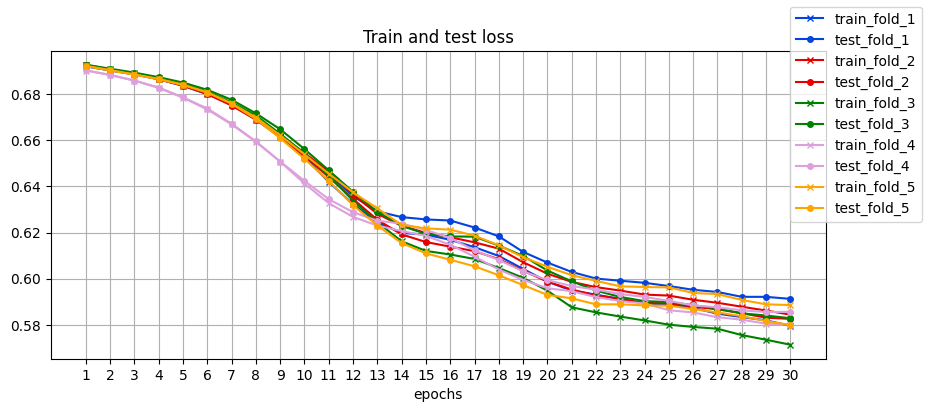

In [ ]:
# plot train and test loss
fig, ax = plt.subplots(figsize=(10,4))
colors = ['#0343DF', '#E50000', '#008000', '#DDA0DD', '#FFA500']
for i in range(n_fold):
    ax.plot(range(1,len(train_loss_all[i])+1), train_loss_all[i], '-x', markersize=4, label=f'train_fold_{i+1}', color=colors[i])
    ax.plot(range(1,len(test_loss_all[i])+1), test_loss_all[i], '-o', markersize=4, label=f'test_fold_{i+1}', color=colors[i])
ax.set_xticks(np.arange(1, epoch+1))
ax.grid()
ax.set_title('Train and test loss')
ax.set_xlabel('epochs')
fig.legend()
fig.show()

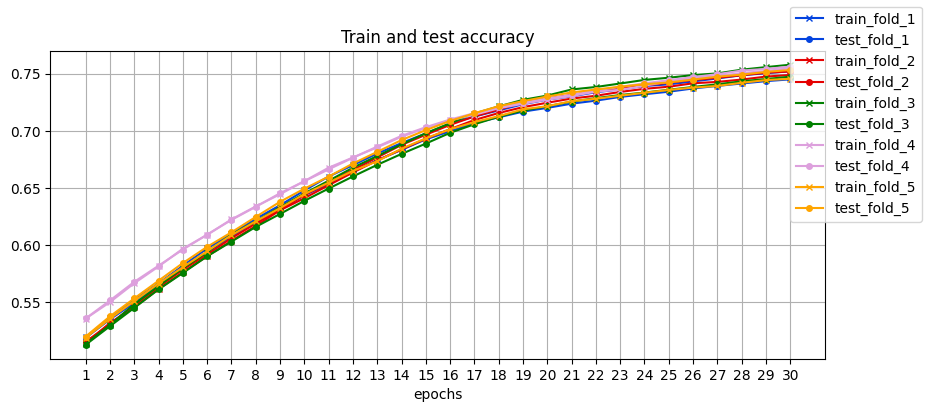

In [ ]:
# plot train and test accuracy
fig, ax = plt.subplots(figsize=(10,4))
for i in range(n_fold):
    ax.plot(range(1,len(train_acc_all[i])+1), train_acc_all[i], '-x', markersize=4, label=f'train_fold_{i+1}', color=colors[i])
    ax.plot(range(1,len(test_acc_all[i])+1), test_acc_all[i], '-o', markersize=4, label=f'test_fold_{i+1}', color=colors[i])
ax.set_xticks(np.arange(1, epoch+1))
ax.grid()
ax.set_title('Train and test accuracy')
ax.set_xlabel('epochs')
fig.legend()
fig.show()

In [ ]:
# print out average accuracy
acc_list = []
for i in range(n_fold):
    acc = test_acc_all[i][-1]
    acc_list.append(acc)
    print(f'Fold {i+1} test accuracy: {acc:.4f}')
print('==============')
print(f'Average accuracy: {np.mean(acc_list):.4f}')

Fold 1 test accuracy: 0.7449
Fold 2 test accuracy: 0.7518
Fold 3 test accuracy: 0.7473
Fold 4 test accuracy: 0.7561
Fold 5 test accuracy: 0.7531
Average accuracy: 0.7506


### Inspect all folds output

In [ ]:
# combine and reorder the outputs
output_sorted = torch.zeros(num_nodes, num_features)

for i in range(n_fold):
    output = torch.load(f'/content/drive/Shareddrives/CS523/Notebooks/output/GAT_600/fold_{i+1}.pt')   # load back saved outputs
    output_masked = output[[test_masks[i]]].cpu().detach()
    print(f'Fold {i+1} output: {output_masked.shape[0]} nodes')
    output_sorted[test_masks[i]] = output_masked   # put output of each folder back to the original order

print('==============')
print(f'All folds output: {output_sorted.shape[0]} nodes')

Fold 1 output: 1525 nodes
Fold 2 output: 1525 nodes
Fold 3 output: 1525 nodes
Fold 4 output: 1525 nodes
Fold 5 output: 1524 nodes
All folds output: 7624 nodes


In [ ]:
if save_results:
    torch.save(output_sorted, f'/content/drive/Shareddrives/CS523/Notebooks/output/GAT_600/all_folds.pt')

In [ ]:
output = torch.load(f'/content/drive/Shareddrives/CS523/Notebooks/output/GAT_600/all_folds.pt')

In [ ]:
torch.where(output>=0.5, 1, 0).sum(axis=0)

tensor([7449, 6088, 4346, 5488, 5313, 5242, 5575, 5114, 4199, 4776, 4243, 4708,
        4292, 4084, 3307, 3936, 4561, 4174, 3614, 3621, 2582, 3026, 3098, 3276,
        2991, 2517, 2598, 3087, 3046, 2370, 2074, 2322, 2433, 1149, 2068, 2033,
        1791, 1772, 2427, 2003, 3009, 2394, 2199, 2024, 1785, 1116, 1290, 1556,
        1548, 1654, 2030, 1932, 1423, 1167,  936, 1315, 1422, 1072, 1671, 1154,
        1198, 1918, 1373, 1768,  955, 1179,  974, 1016,  908,  704,  886, 1382,
        1099, 1356, 1090, 1380, 1137,  541,  913,  634,  961,  695,  475, 1012,
         910,  846, 1118, 1670,  941, 1324, 1681,  447,  565,  559,  762,  189,
        1026,  787,  413,  414,  922,  462,  458,  765,  578,  314,  125,  315,
         793,  627,  657,  519,  389,  901,  879, 1002,  734,  470,  724,  266,
         360,  881,  202,  661, 1271,  570,  171,  740,  612,  304,  121,  579,
         545,  217,  578,  794,  326,  437,  285,  822,  644,  298, 1069,  537,
         205,  308,   96,  318,  443,  1

In [ ]:
data.x.sum(axis=1).cpu()

tensor([240., 136.,  83.,  ..., 191., 233.,  74.])

In [ ]:
torch.where(output>=0.5, 1, 0).sum(axis=1)

tensor([69, 57, 62,  ..., 28, 46, 31])